# AlexNet by Tensorflow2 Keras

## Dataset

Cifa10, downloading source: https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz

After downloading it, please unzip the folder: cifar-10-batches-py in this zipped file to current folder: ./cifar10/data/

In [1]:
import pickle
import os.path
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.datasets import cifar10, cifar
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout, Flatten
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.python.keras.callbacks import LambdaCallback
from tensorflow.python.keras.callbacks import TensorBoard
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer

In [2]:
# Hyperparameters
batch_size = 128
num_classes = 10
epochs = 100

In [3]:
path = './alex_cifar10/'
os.makedirs(path, exist_ok=True)
epoch_file=os.path.join(path, "epoch_num.txt")
data_file=os.path.join(path, "data.txt")
filepath=os.path.join(path, "weights.best.hdf5")

In [4]:
def load_data():
    path = './cifar10/data/cifar-10-batches-py/'
    if os.path.exists(path):
        num_train_samples = 50000

        x_train = np.empty((num_train_samples, 3, 32, 32), dtype='uint8')
        y_train = np.empty((num_train_samples,), dtype='uint8')

        for i in range(1, 6):
            fpath = os.path.join(path, 'data_batch_' + str(i))
            (x_train[(i - 1) * 10000:i * 10000, :, :, :],
             y_train[(i - 1) * 10000:i * 10000]) = cifar.load_batch(fpath)

        fpath = os.path.join(path, 'test_batch')
        x_test, y_test = cifar.load_batch(fpath)

        y_train = np.reshape(y_train, (len(y_train), 1))
        y_test = np.reshape(y_test, (len(y_test), 1))

        if K.image_data_format() == 'channels_last':
            x_train = x_train.transpose(0, 2, 3, 1)
            x_test = x_test.transpose(0, 2, 3, 1)

        x_test = x_test.astype(x_train.dtype)
        y_test = y_test.astype(y_train.dtype)
    else:
        (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    return (x_train, y_train), (x_test, y_test)

In [5]:
# Load CIFAR10 Data
(x_train, y_train), (x_test, y_test) = load_data()
img_height, img_width, channel = x_train.shape[1],x_train.shape[2],x_train.shape[3]
print(img_height, img_width, channel)
print(len(x_train), len(x_test))

32 32 3
50000 10000


In [6]:
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [7]:
def AlexNet(input_shape=(32, 32, 3, ), num_classes=2):
    # AlexNet Define the Model
    model = Sequential()
    # model.add(Conv2D(96, (11,11), strides=(4,4), activation='relu', padding='same', input_shape=(img_height, img_width, channel,)))
    # for original Alexnet
    model.add(Conv2D(48, (3,3), strides=(2,2), activation='relu', padding='same', 
                     input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
    # Local Response normalization for Original Alexnet
    model.add(BatchNormalization())

    model.add(Conv2D(96, (3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2,2)))
    # Local Response normalization for Original Alexnet
    model.add(BatchNormalization())

    model.add(Conv2D(192, (3,3), activation='relu', padding='same'))
    model.add(Conv2D(192, (3,3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2,2)))
    # Local Response normalization for Original Alexnet
    model.add(BatchNormalization())

    model.add(Flatten())
    # model.add(Dense(512, activation='tanh'))
    # model.add(Dropout(0.5))
    model.add(Dense(256, activation='tanh'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    return model

In [8]:
model = AlexNet(input_shape=(img_height, img_width, channel,), num_classes=num_classes)

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 48)        1344      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 8, 48)          0         
_________________________________________________________________
batch_normalization (BatchNo (None, 8, 8, 48)          192       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 96)          41568     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 96)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 3, 3, 96)          384       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 192)         1

In [10]:
report_data = {
    "accuracy":[],
    "val_accuracy":[],
    "loss":[],
    "val_loss":[]
}

num_epoch = 0
if not os.path.isfile(epoch_file):
    with open(epoch_file, "w+") as file:  
        file.write(str(num_epoch))
else:
    with open(epoch_file, "r") as file:  
        num_epoch = int(file.read())

if os.path.isfile(filepath):
    model.load_weights(filepath)

if os.path.isfile(data_file):
    with open(data_file, "rb") as file:
        report_data = pickle.load(file)

In [11]:
# determine Loss function and Optimizer
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

In [12]:
def updateEpoch(epoch, logs):
    to_save = num_epoch + epoch + 1
    report_data['accuracy'].append(logs['accuracy'])
    report_data['loss'].append(logs['loss'])
    report_data['val_accuracy'].append(logs['val_accuracy'])
    report_data['val_loss'].append(logs['val_loss'])
    with open(epoch_file, "w") as file:  
        file.write(str(to_save))
    with open(data_file, "wb") as file:
        pickle.dump(report_data, file)
    print(epoch, logs)

In [13]:
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='auto')
ealry_stopping = EarlyStopping(monitor='loss', 
                              patience=15,
                              verbose=1,
                              mode='auto')
lambdaCall = LambdaCallback(on_epoch_end=updateEpoch)

In [14]:
callbacks_list = [checkpoint, ealry_stopping, lambdaCall]

In [15]:
# Train the Model
history = model.fit(x_train, 
                    y_train,
                    batch_size=batch_size,
                    epochs=(epochs - num_epoch),
                    verbose=1,
                    callbacks=callbacks_list,
                    validation_data=(x_test, y_test))

Epoch 1/100
391/391 [==============================] - 9s 15ms/step - loss: 1.6675 - accuracy: 0.4093 - val_loss: 1.2375 - val_accuracy: 0.5589

Epoch 00001: loss improved from inf to 1.42575, saving model to ./alex_cifar10\weights.best.hdf5
0 {'loss': 1.4257527589797974, 'accuracy': 0.49327999353408813, 'val_loss': 1.2375282049179077, 'val_accuracy': 0.558899998664856}
Epoch 2/100
391/391 [==============================] - 4s 12ms/step - loss: 1.0752 - accuracy: 0.6253 - val_loss: 1.2205 - val_accuracy: 0.5849

Epoch 00002: loss improved from 1.42575 to 1.03572, saving model to ./alex_cifar10\weights.best.hdf5
1 {'loss': 1.0357184410095215, 'accuracy': 0.6410599946975708, 'val_loss': 1.2204647064208984, 'val_accuracy': 0.5849000215530396}
Epoch 3/100
391/391 [==============================] - 5s 12ms/step - loss: 0.8667 - accuracy: 0.7002 - val_loss: 0.9558 - val_accuracy: 0.6676

Epoch 00003: loss improved from 1.03572 to 0.86036, saving model to ./alex_cifar10\weights.best.hdf5
2 {'

391/391 [==============================] - 6s 15ms/step - loss: 0.0672 - accuracy: 0.9770 - val_loss: 1.5053 - val_accuracy: 0.7130

Epoch 00023: loss improved from 0.07873 to 0.07345, saving model to ./alex_cifar10\weights.best.hdf5
22 {'loss': 0.07345347106456757, 'accuracy': 0.9750400185585022, 'val_loss': 1.505286455154419, 'val_accuracy': 0.7129999995231628}
Epoch 24/100
391/391 [==============================] - 6s 15ms/step - loss: 0.0748 - accuracy: 0.9738 - val_loss: 1.4404 - val_accuracy: 0.7252

Epoch 00024: loss did not improve from 0.07345
23 {'loss': 0.07685689628124237, 'accuracy': 0.9738399982452393, 'val_loss': 1.440429925918579, 'val_accuracy': 0.7251999974250793}
Epoch 25/100
391/391 [==============================] - 6s 15ms/step - loss: 0.0519 - accuracy: 0.9830 - val_loss: 1.5919 - val_accuracy: 0.7144

Epoch 00025: loss improved from 0.07345 to 0.06511, saving model to ./alex_cifar10\weights.best.hdf5
24 {'loss': 0.06511090695858002, 'accuracy': 0.978020012378692

391/391 [==============================] - 6s 15ms/step - loss: 0.0273 - accuracy: 0.9918 - val_loss: 1.7235 - val_accuracy: 0.7138

Epoch 00047: loss improved from 0.03586 to 0.03585, saving model to ./alex_cifar10\weights.best.hdf5
46 {'loss': 0.03585435450077057, 'accuracy': 0.9887800216674805, 'val_loss': 1.7234632968902588, 'val_accuracy': 0.7138000130653381}
Epoch 48/100
391/391 [==============================] - 6s 15ms/step - loss: 0.0354 - accuracy: 0.9888 - val_loss: 1.6100 - val_accuracy: 0.7245

Epoch 00048: loss did not improve from 0.03585
47 {'loss': 0.038296815007925034, 'accuracy': 0.9876000285148621, 'val_loss': 1.6099709272384644, 'val_accuracy': 0.7245000004768372}
Epoch 49/100
391/391 [==============================] - 6s 15ms/step - loss: 0.0331 - accuracy: 0.9893 - val_loss: 1.6733 - val_accuracy: 0.7302

Epoch 00049: loss improved from 0.03585 to 0.03345, saving model to ./alex_cifar10\weights.best.hdf5
48 {'loss': 0.03345226123929024, 'accuracy': 0.989099979400


Epoch 00071: loss did not improve from 0.02167
70 {'loss': 0.027781503275036812, 'accuracy': 0.9910200238227844, 'val_loss': 1.9037660360336304, 'val_accuracy': 0.7056999802589417}
Epoch 72/100
391/391 [==============================] - 6s 15ms/step - loss: 0.0230 - accuracy: 0.9925 - val_loss: 1.7811 - val_accuracy: 0.7221

Epoch 00072: loss did not improve from 0.02167
71 {'loss': 0.024493152275681496, 'accuracy': 0.9918400049209595, 'val_loss': 1.781137466430664, 'val_accuracy': 0.722100019454956}
Epoch 73/100
391/391 [==============================] - 6s 15ms/step - loss: 0.0219 - accuracy: 0.9932 - val_loss: 1.6423 - val_accuracy: 0.7403

Epoch 00073: loss did not improve from 0.02167
72 {'loss': 0.025542905554175377, 'accuracy': 0.9918599724769592, 'val_loss': 1.64228355884552, 'val_accuracy': 0.7402999997138977}
Epoch 74/100
391/391 [==============================] - 6s 15ms/step - loss: 0.0188 - accuracy: 0.9940 - val_loss: 1.7010 - val_accuracy: 0.7382

Epoch 00074: loss did 

391/391 [==============================] - 6s 15ms/step - loss: 0.0155 - accuracy: 0.9951 - val_loss: 1.8549 - val_accuracy: 0.7285

Epoch 00096: loss did not improve from 0.01562
95 {'loss': 0.017234254628419876, 'accuracy': 0.9945799708366394, 'val_loss': 1.8548880815505981, 'val_accuracy': 0.7285000085830688}
Epoch 97/100
391/391 [==============================] - 6s 15ms/step - loss: 0.0174 - accuracy: 0.9945 - val_loss: 1.8128 - val_accuracy: 0.7284

Epoch 00097: loss did not improve from 0.01562
96 {'loss': 0.02038308046758175, 'accuracy': 0.9935799837112427, 'val_loss': 1.8127541542053223, 'val_accuracy': 0.7283999919891357}
Epoch 98/100
391/391 [==============================] - 6s 15ms/step - loss: 0.0160 - accuracy: 0.9948 - val_loss: 1.8109 - val_accuracy: 0.7401

Epoch 00098: loss did not improve from 0.01562
97 {'loss': 0.01614512875676155, 'accuracy': 0.9947599768638611, 'val_loss': 1.810882568359375, 'val_accuracy': 0.7401000261306763}
Epoch 99/100
391/391 [=============

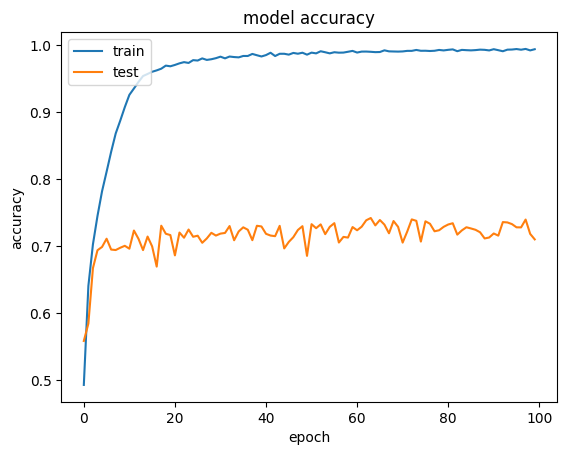

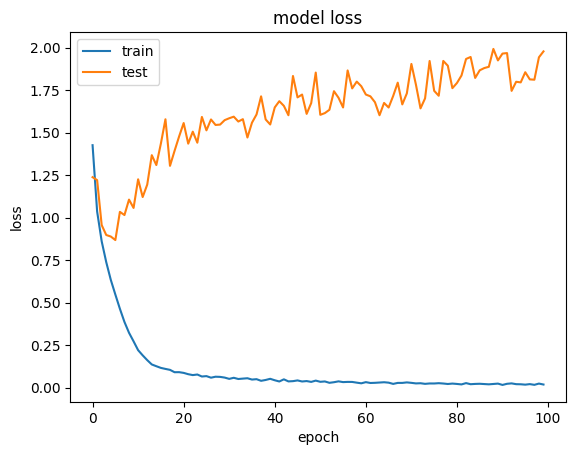

313/313 [==============================] - 1s 3ms/step - loss: 1.9774 - accuracy: 0.7105
Test loss: 1.9774200916290283
Test accuracy: 0.7105000019073486
313/313 [==============================] - 1s 2ms/step


In [16]:
# summarize history for accuracy
plt.plot(report_data['accuracy'])
plt.plot(report_data['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(report_data['loss'])
plt.plot(report_data['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Test the model
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
predictions = model.predict(x_test, verbose=1)

In [17]:
def load_label_names():
    return ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [101]:
from sklearn.preprocessing import MinMaxScaler
import random
preprocess = MinMaxScaler()
  
def display_image_predictions(features, labels, predictions):
    n_classes = 10
    sample_number = 15
    label_names = load_label_names()
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(range(n_classes))
    label_ids = label_binarizer.inverse_transform(np.array(labels))

    fig, axs = plt.subplots(sample_number, 2, figsize=(12,24))
    margin = 0.05
    ind = np.arange(n_classes)
    width = (1. - 2. * margin) / n_classes
    result_list = []
    for i, prediction in enumerate(predictions):
        data = {}
        data['label_id'] = label_ids[i]
        data['label_name'] = label_names[data['label_id']]
        data['pred_id'] = np.argmax(prediction)
        data['pred_name'] = label_names[data['pred_id']]
        data['feature'] = features[i]
        data['prediction_scale'] = preprocess.fit_transform(prediction[:,np.newaxis]).ravel()
        result_list.append(data)
    
    random.shuffle(result_list)
#     print(len(result_list))
    for i in range(sample_number):
        feature = result_list[i]['feature']
        pred_name = result_list[i]['pred_name']
        label_name = result_list[i]['label_name']
        prediction = result_list[i]['prediction_scale']
        axs[i][0].imshow(feature)
        axs[i][0].set_title('gt:'+label_name+'_'+'pred:'+pred_name)
        axs[i][0].set_axis_off()

        axs[i][1].barh(ind + margin, prediction, width)
        axs[i][1].set_yticks(ind + margin)
        axs[i][1].set_yticklabels(label_names)

    plt.tight_layout()

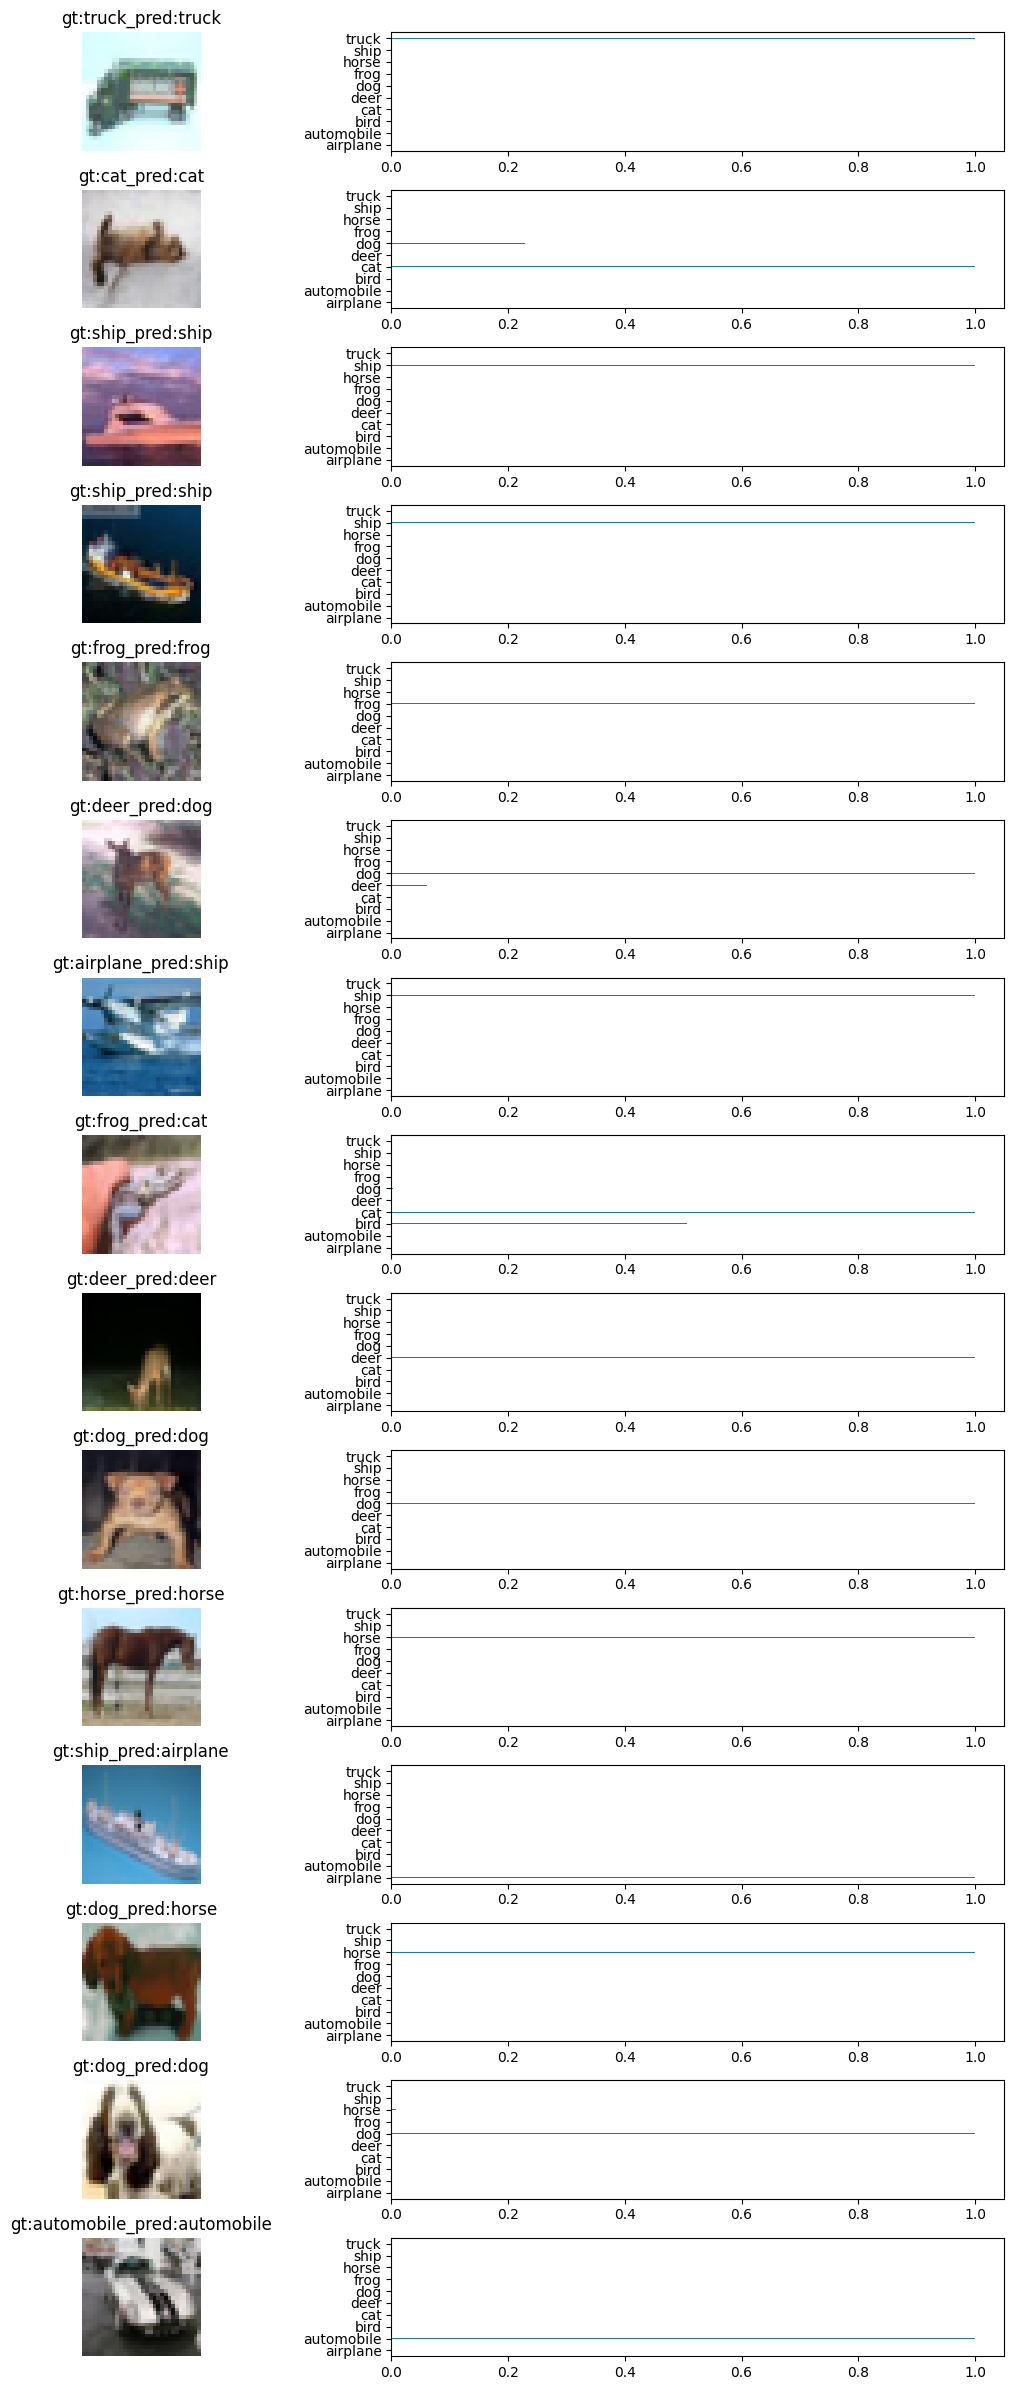

In [102]:
display_image_predictions(x_test, y_test, predictions)